In [2]:
import numpy as np
import cv2 as cv
import os
from sklearn import svm
from skimage.feature import hog
import matplotlib.pyplot as plt
import re

In [3]:
treinamentoDiretorio = "CAPTCHA-10k/treinamento"
labelsDiretorio = "CAPTCHA-10k/labels10k/"
validacaoDiretorio = "CAPTCHA-10k/validacao"

In [4]:
regioes = [35, 65, 95, 125, 155]
tamanhoDaRegiao = 2048

In [5]:
def padding_img(img: np.ndarray, multiply_of: int):
    nLines, nCols = img.shape
    
    pad_row = 0 if nLines % multiply_of == 0 else multiply_of - nLines % multiply_of
    pad_col = 0 if nCols % multiply_of == 0 else multiply_of - nCols % multiply_of

    pad_width = ((0, pad_row), (0, pad_col)) # 
    return np.pad(img, pad_width, mode='maximum') 

In [6]:
def returna_regioes(img, regioes):
    img_regioes = []

    regioes = [5] + regioes + [img.shape[1]]

    for i in range(len(regioes)-1):
        img_regioes.append(img[:, regioes[i]:regioes[i+1]])


    return img_regioes


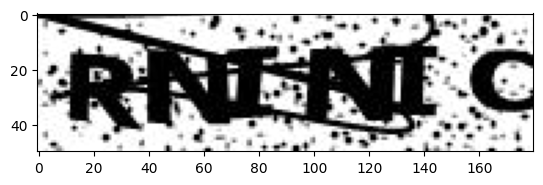

0.1658709437362154


In [108]:
def dx(img):
    img = np.array(img, dtype=np.int64)
    M, N = img.shape

    DX = np.zeros((M-2, N-2), dtype=np.int64)

    for i in range(1, M-1):
        for j in range(1, N-1):
            DX[i-1][j-1] = np.subtract(img[i][j - 1], img[i][j + 1]) 
    return DX

def dy(img):
    img = np.array(img, dtype=np.int64)
    M, N = img.shape
    DY = np.zeros((M-2, N-2), dtype=np.int64)

    for i in range(1, M-1):
        for j in range(1, N-1):
            DY[i-1][j-1] = np.subtract(img[i-1][j], img[i+1][j])
    return DY

def gradient(img):
    DX = dx(img)
    DY = dy(img)
    
    magnitude = np.sqrt(DY**2 + DX**2)

    # avoid zero division
    DX = np.array(DX, dtype=np.float128)
    filter = DX == 0
    DX[filter] = 0.0001

    angle = (np.arctan(DY/DX))

    # transform negative angles to positive
    filter = angle < 0
    angle[filter] += np.pi

    # convert rad to angle
    angle *= 180/np.pi

    return magnitude, np.abs(angle)

def CaptchaToCharacters(mag, angle):
    char1 = {
        'magnitude': mag[:48, 0:30],
        'angle': angle[:48, 0:30]
    }
    char2 = {
        'magnitude': mag[:48, 29:59],
        'angle': angle[:48, 29:59]
    }
    char3 = {
        'magnitude': mag[:48, 59:89],
        'angle': angle[:48, 59:89]
    }
    char4 = {
        'magnitude': mag[:48, 89:119],
        'angle': angle[:48, 89:119]
    }
    char5 = {
        'magnitude': mag[:48, 119:149],
        'angle': angle[:48, 119:149]
    }
    char6 = {
        'magnitude': mag[:48, 148:178],
        'angle': angle[:48, 148:178]
    }
    return [char1, char2, char3, char4, char5, char6]

def hogChar(magnitude, angle):
    # This hog use a 2x2 windown where each cell has 8x6 px and 4x3 px.
    M, N = magnitude.shape

    # calculate the cells, 8x6 px and 4x3 px.
    cellsHist8X6 = np.zeros((6, 5, 9))
    for i in range(M//8):
        for j in range(N//6):
            index = angle[i*8:i*8+8, j*6:j*6+6].flatten()/20
            m = magnitude[i*8:i*8+8, j*6:j*6+6].flatten()

            for k in range(48):
                id = int(index[k]//1)
                idFraction = index[k] - id

                if id >= 8:
                    cellsHist8X6[i][j][id] += m[k]
                else:
                    cellsHist8X6[i][j][id] += (1 - idFraction) * m[k]
                    cellsHist8X6[i][j][id + 1] += idFraction * m[k]

    
    cellsHist4X3 = np.zeros((12, 10, 9))
    for i in range(M//4):
        for j in range(N//3):
            index = angle[i*4:i*4+4, j*3:j*3+3].flatten()/20
            m = magnitude[i*4:i*4+4, j*3:j*3+3].flatten()

            for k in range(12):
                id = int(index[k]//1)
                idFraction = index[k] - id

                if id >= 8:
                    cellsHist4X3[i][j][id] += m[k]
                else:
                    cellsHist4X3[i][j][id] += (1 - idFraction) * m[k]
                    cellsHist4X3[i][j][id + 1] += idFraction * m[k]
    
    # Calculate the hog from the 2x2 window
    #8x6 cells
    hog8X6 = np.zeros((720, ))
    for i in range(5):
        for j in range(4):
            window = cellsHist8X6[i:i+2, j:j+2, :]
            hog8X6[(i*4 + j)*36:(i*4 + j)*36+36] = np.concatenate((window[0][0], window[0][1], window[1][0], window[1][1]))
    
    #4x3 cells
    hog4X3 = np.zeros((3564, ))
    for i in range(11):
        for j in range(9):
            window = cellsHist4X3[i:i+2, j:j+2, :]
            hog4X3[(i*9 + j)*36:(i*9 + j)*36+36] = np.concatenate((window[0][0], window[0][1], window[1][0], window[1][1]))
    
    hogNormalized = np.concatenate((hog8X6, hog4X3))
    hogNormalized /= np.sqrt((hogNormalized**2).sum() + 0.1)
    return hogNormalized

    

        

def hogCaptcha(captchaPATH):
    captcha = cv.imread(captchaPATH, cv.IMREAD_GRAYSCALE)
    captcha = np.array(captcha, dtype=np.int64)

    magnitude, angle = gradient(captcha)

    charsGradient = CaptchaToCharacters(magnitude, angle)

    a = hogChar(charsGradient[0]['magnitude'], charsGradient[0]['angle'])
    



img = cv.imread('./CAPTCHA-10k/treinamento/000001.jpg', cv.IMREAD_GRAYSCALE)
img = np.array(img, dtype=np.int64)
plt.imshow(img, cmap='gray')
plt.show()
hogCaptcha('./CAPTCHA-10k/treinamento/000001.jpg')



In [8]:
a = np.array([
            [1,2,3,4,5,4,3,2,1],
            [1,2,3,4,5,4,3,2,1],
            [1,2,3,4,5,4,3,2,1],
            [1,2,3,4,5,4,3,2,1],
            [1,2,3,4,5,4,3,2,1],
             ])

a[1:3, 2:4]

array([[3, 4],
       [3, 4]])

In [9]:
def myHog(img):
   return hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys',feature_vector=True, channel_axis=None)

In [10]:
def hogTrainingFeatures():
    features = []
    
    files = os.listdir(treinamentoDiretorio)
    
    for file in files:
        filePath = os.path.join(treinamentoDiretorio, file)
        img = cv.imread(filePath, cv.IMREAD_GRAYSCALE)

        imgs = returna_regioes(img, regioes)

        for i in imgs:
            i = padding_img(i, 16)
            if i.size != tamanhoDaRegiao:
                print("Erro todas as regioes precisam ter o mesmo tamanho")
        
        for i in imgs:
            features.append(myHog(i))

    return features



In [11]:

# Retorna as Labels de Treino
def getTrainingLabels():
    labelsArr = []
    files = os.listdir(treinamentoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labelsArr += list(label)
    
    return np.asarray(labelsArr)


In [12]:
features = hogTrainingFeatures()
features = np.asarray(features)

labelsArr = getTrainingLabels()


# Training phase
clf = svm.SVC()
clf.fit(features, labelsArr)

KeyboardInterrupt: 

# Validação


In [ ]:
def predictCaptha(model, imgPath):
    # prediz o captcha da imagem 'imgPath' no modelo 'model'
    
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    imgs = returna_regioes(img, regioes)


    features = []
    for i in imgs:
        features.append(myHog(i))
    features = np.asarray(features)
    return model.predict(features)
    


In [ ]:
def validation(model):
    features = []
    files = os.listdir(validacaoDiretorio)
    
    for file in files:
        filePath = os.path.join(validacaoDiretorio, file)
        img = cv.imread(filePath, cv.IMREAD_GRAYSCALE)

        imgs = returna_regioes(img, regioes)

        for i in imgs:
            i = padding_img(i, 16)
            if i.size != tamanhoDaRegiao:
                print("Erro todas as regioes precisam ter o mesmo tamanho")
        
        for i in imgs:
            features.append(myHog(i))

    features = np.asarray(features)
    predict = model.predict(features)


    labels = []
    files = os.listdir(validacaoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labels += list(label)
    labels = np.asarray(labels)


    return (predict, labels)

predict, labels = validation(clf)

# Análise


In [ ]:
def numOfMatches(strA, strB):
    return (strA == strB).sum()

def createAnalitic(predict, labels):
    numCaptchas = len(labels) // 6

    histogram = [0, 0, 0, 0, 0, 0, 0]

    for i in range(numCaptchas):
        nMatch = numOfMatches(predict[i*6:i*6 + 6], labels[i*6:i*6 + 6])
        for j in range(nMatch + 1):
            histogram[j] += 1
    

    
    X = [0, 1, 2, 3, 4, 5, 6]
    histogram = np.asarray(histogram)
    histogram = histogram / histogram[0]
    plt.plot(X, histogram, '-r')
    plt.title("Taxa de reconhecimento para pelomenos n caracteres")
    plt.show()

createAnalitic(predict, labels)
